In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn import linear_model

%matplotlib inline

In [383]:
my_data = pd.read_csv('/home/lin/教材/MearchineLearning/assignmentOneData/48EqualWeighted.csv')

my_data['Unnamed: 0'] = pd.to_datetime(my_data['Unnamed: 0'])

print( np.unique(my_data['Unnamed: 0']).shape, my_data['Unnamed: 0'].shape)

my_data.set_index('Unnamed: 0', inplace = True)
N_ASSET = my_data.shape[1]

my_data.dtypes

(12196,) (12196,)


Agric    float64
Food     float64
Soda     float64
Beer     float64
Smoke    float64
Toys     float64
Fun      float64
Books    float64
Hshld    float64
Clths    float64
Hlth     float64
MedEq    float64
Drugs    float64
Chems    float64
Rubbr    float64
Txtls    float64
BldMt    float64
Cnstr    float64
Steel    float64
FabPr    float64
Mach     float64
ElcEq    float64
Autos    float64
Aero     float64
Ships    float64
Guns     float64
Gold     float64
Mines    float64
Coal     float64
Oil      float64
Util     float64
Telcm    float64
PerSv    float64
BusSv    float64
Comps    float64
Chips    float64
LabEq    float64
Paper    float64
Boxes    float64
Trans    float64
Whlsl    float64
Rtail    float64
Meals    float64
Banks    float64
Insur    float64
RlEst    float64
Fin      float64
Other    float64
dtype: object

In [6]:
my_data.head()

,Unnamed: 0,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
0,1969-07-01,0.00,0.62,0.43,0.54,0.18,0.78,0.84,-0.01,0.58,...,1.19,0.66,0.66,0.38,1.22,0.25,0.50,0.99,0.61,1.79
1,1969-07-02,0.76,1.11,0.27,1.29,0.16,2.05,1.43,1.59,1.32,...,1.85,0.81,1.65,0.84,1.39,1.47,1.77,0.94,1.22,1.04
2,1969-07-03,0.31,1.23,0.50,2.02,1.59,1.40,0.83,0.79,1.03,...,1.73,0.87,1.14,0.79,1.57,2.14,0.46,2.13,1.25,3.06
3,1969-07-07,-0.04,-0.59,-0.41,0.11,-0.02,-0.43,-1.51,-0.04,-0.53,...,-0.82,-0.98,-0.60,-0.20,-1.34,-0.26,-1.07,-1.62,-0.61,-1.68
4,1969-07-08,0.46,-0.89,-0.79,-1.19,-1.09,-1.66,-1.68,-0.55,-1.46,...,-1.25,-1.25,-1.63,-1.22,-1.82,-1.15,-1.72,-2.13,-1.58,-2.83


In [8]:
my_data.isnull().any()

Agric    False
Food     False
Soda     False
Beer     False
Smoke    False
Toys     False
Fun      False
Books    False
Hshld    False
Clths    False
Hlth     False
MedEq    False
Drugs    False
Chems    False
Rubbr    False
Txtls    False
BldMt    False
Cnstr    False
Steel    False
FabPr    False
Mach     False
ElcEq    False
Autos    False
Aero     False
Ships    False
Guns     False
Gold     False
Mines    False
Coal     False
Oil      False
Util     False
Telcm    False
PerSv    False
BusSv    False
Comps    False
Chips    False
LabEq    False
Paper    False
Boxes    False
Trans    False
Whlsl    False
Rtail    False
Meals    False
Banks    False
Insur    False
RlEst    False
Fin      False
Other    False
dtype: bool

In [384]:
def sig_fit(clf, sigma):
    a = np.append([1.] * N_ASSET, sigma)
    a = np.reshape(a, [N_ASSET + 1, N_ASSET])
    b = [1] + [0] * N_ASSET
    return clf.fit(a, b)

In [385]:
def cross_vali_for_lambda(trainning_set, lambdaSet, fold = 10, reg_type=linear_model.Lasso, seed = None):
    
    if seed is None:
        seed = np.random.randint(1, 12345678)
        
    nObs = trainning_set.shape[0] 
    eachFold = nObs / fold
    shuffleSet = trainning_set.sample(frac = 1, random_state=seed).reset_index(drop = True)
    start_drop = 0
    stdSeries = np.ones([fold, lambdaSet.shape[0]]) * (-1)
    
    balls = 0
    
    for i in range(1, fold + 1):
        sample = shuffleSet.drop(range(int(start_drop), int(start_drop + eachFold)))
        
        testSet = shuffleSet[int(start_drop):int(start_drop + eachFold)]
        start_drop += eachFold
        
      
                
        sigma = np.cov(sample.T)
        if sigma.shape != (N_ASSET, N_ASSET):
            print("Error from cost_fun: sigma has wrong dimention")
        j = 0
        
        for lambdaValue in lambdaSet:
            clf = reg_type(alpha=lambdaValue, fit_intercept=False)
            sig_fit(clf, sigma)
            if clf.coef_.sum() == 0:
                print("Error: cross_vali_for_lambda Sum of coef is zero, too sparse, try smaller lambda")
            weights = clf.coef_ / clf.coef_.sum()
            returns = testSet @ weights
            stdSeries[i-1, j] = returns.std()
            j += 1
        means = stdSeries.mean(0)
        lambdaOfChoice = lambdaSet[means == means.min()]

            
    return means, lambdaOfChoice[0]

In [301]:
def Markowitz_weights_opt(Sigma, nonnegative = False, print_info = False):
    
    n = Sigma.shape[0]    
    x0 = np.ones(n)/n

    cost_fun = lambda x: (x@Sigma)@x
    
        
    if nonnegative:
        cons = ({'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1},
                {'type': 'ineq', 'fun': lambda x: x})

    else:
        cons = ({'type': 'eq', 'fun': lambda x: x@np.ones(n) - 1})

    # Calculate efficient frontier weights using quadratic programming
    res = minimize(cost_fun, x0, method = 'SLSQP', constraints=cons)
    if print_info:
        print(res)

    return res.x

In [392]:
trainningSet = my_data.iloc[: 250]
lambdaSeries = np.logspace(-5, -2, 100) #just for test
sigma = np.ones((N_ASSET, N_ASSET))
stds, lam = cross_vali_for_lambda(trainningSet, lambdaSeries, seed=60)
print(lam)
plt.plot(lambdaSeries, stds)
plt.show()

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.005336699231206312


In [387]:
lambdaSeries = np.logspace(-7, -2, 100)
stds, lam = cross_vali_for_lambda(trainningSet, lambdaSeries, reg_type=linear_model.Ridge)
print(lam)
plt.plot(lambdaSeries, stds)

0.01


In [127]:
lams_two = np.ones(20)

for index in range(20):
    trainningSet = my_data.iloc[: 500]
    lambdaSeries = np.logspace(-12, -9, 100)
    stds, lam = cross_vali_for_lambda(trainningSet, lambdaSeries)
    lams_two[index] = lam
    plt.plot(lambdaSeries, stds)
    plt.show()

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(10, 800)


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


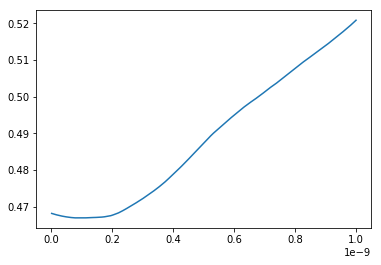

(10, 800)


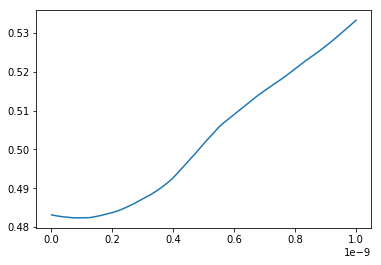

(10, 800)


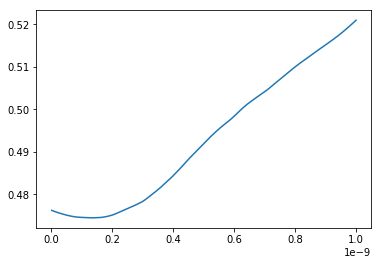

(10, 800)


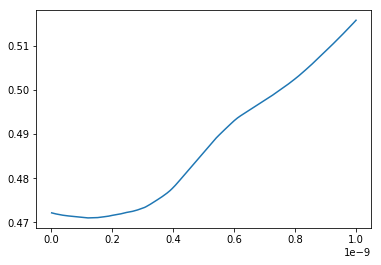

(10, 800)


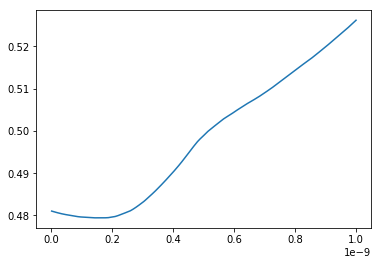

(10, 800)


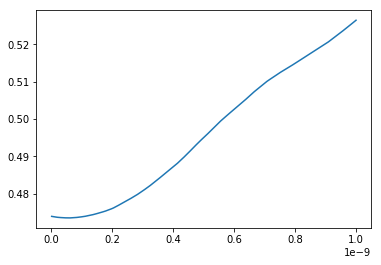

(10, 800)


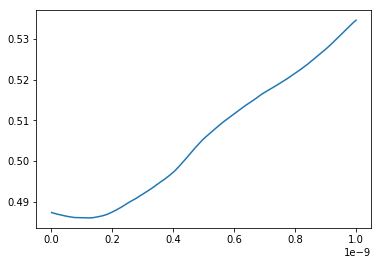

(10, 800)


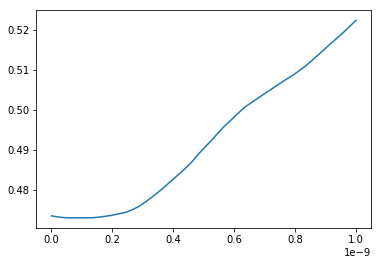

(10, 800)


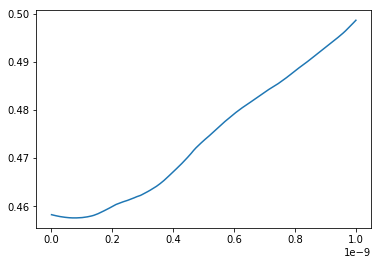

(10, 800)


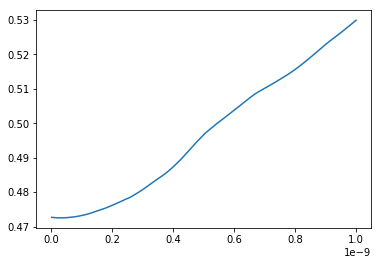

(10, 800)


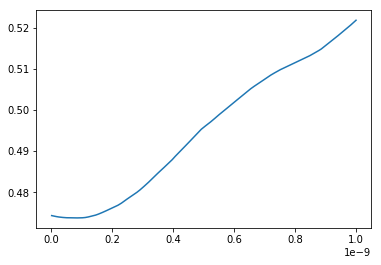

(10, 800)


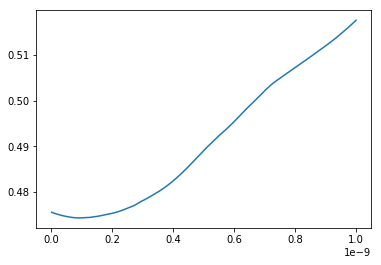

(10, 800)


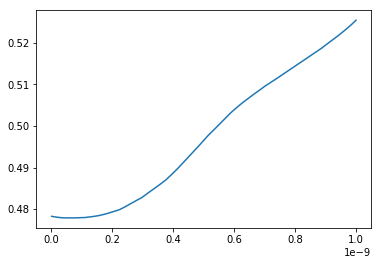

(10, 800)


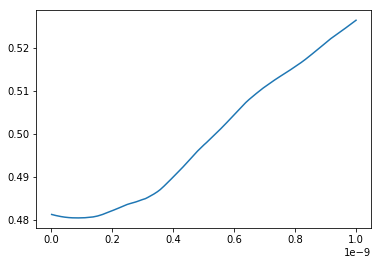

(10, 800)


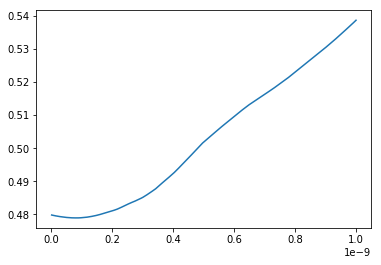

(10, 800)


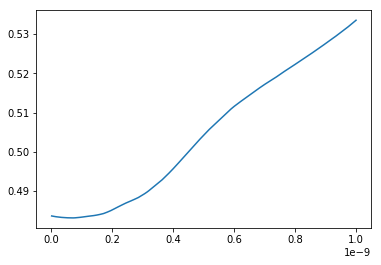

(10, 800)


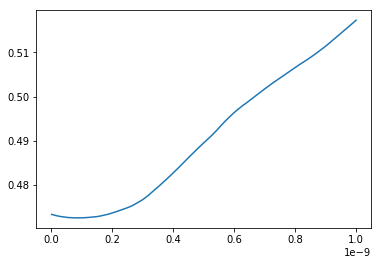

(10, 800)


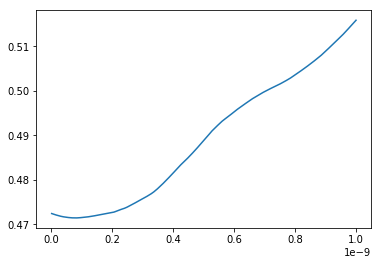

(10, 800)


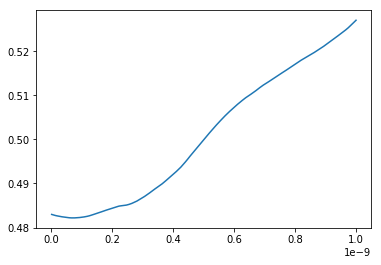

(10, 800)


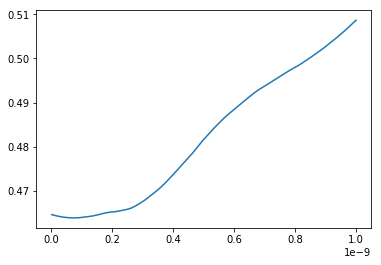

In [11]:
lams = np.ones(20)

for index in range(20):
    trainningSet = my_data.iloc[: 250]
    lambdaSeries = np.logspace(-12, -9, 800)
    stds, lam = cross_vali_for_lambda(trainningSet, lambdaSeries)
    lams[index] = lam
    plt.plot(lambdaSeries, stds)
    plt.show()

In [128]:
lams_two

array([2.31012970e-10, 2.65608778e-10, 2.47707636e-10, 2.47707636e-10,
       2.84803587e-10, 2.31012970e-10, 2.65608778e-10, 2.31012970e-10,
       2.47707636e-10, 2.65608778e-10, 2.84803587e-10, 2.47707636e-10,
       2.65608778e-10, 3.05385551e-10, 2.47707636e-10, 2.47707636e-10,
       3.05385551e-10, 2.65608778e-10, 2.47707636e-10, 2.15443469e-10])

In [129]:
lams

array([8.65808365e-11, 8.96273489e-11, 1.29984739e-10, 1.18192723e-10,
       1.57215593e-10, 5.76701643e-11, 1.26656734e-10, 9.77209059e-11,
       7.94099356e-11, 3.06802273e-11, 8.50966357e-11, 9.04055815e-11,
       5.47549049e-11, 8.58355282e-11, 8.14964936e-11, 6.97516432e-11,
       8.96273489e-11, 7.94099356e-11, 7.09682065e-11, 6.97516432e-11])

In [16]:
lams_two = np.array([2.83018463e-10, 2.44334606e-10, 2.31983353e-10, 2.59577972e-10,
       3.11255042e-10, 2.31983353e-10, 2.48596133e-10, 2.50754688e-10,
       2.50754688e-10, 2.46456158e-10, 2.95520924e-10, 2.71044938e-10,
       2.75772330e-10, 2.38078897e-10, 3.42308767e-10, 2.55128190e-10,
       3.19433511e-10, 2.80582173e-10, 3.05919393e-10, 2.80582173e-10])

In [17]:
lams = np.array([8.65808365e-11, 8.96273489e-11, 1.29984739e-10, 1.18192723e-10,
       1.57215593e-10, 5.76701643e-11, 1.26656734e-10, 9.77209059e-11,
       7.94099356e-11, 3.06802273e-11, 8.50966357e-11, 9.04055815e-11,
       5.47549049e-11, 8.58355282e-11, 8.14964936e-11, 6.97516432e-11,
       8.96273489e-11, 7.94099356e-11, 7.09682065e-11, 6.97516432e-11])

In [18]:
lams.std()

2.7868102593131687e-11

In [19]:
lams_two.std()

3.0305221937098056e-11

In [21]:
(lams.max() - lams.min())/lams.std()

4.540508822842702

In [22]:
(lams_two.max() - lams_two.min())/lams_two.std()

3.6404753685352635

In [29]:
lams_two_lag = np.array([2.44334606e-10, 2.31983353e-10, 2.59577972e-10,
       3.11255042e-10, 2.31983353e-10, 2.48596133e-10, 2.50754688e-10,
       2.50754688e-10, 2.46456158e-10, 2.95520924e-10, 2.71044938e-10,
       2.75772330e-10, 2.38078897e-10, 3.42308767e-10, 2.55128190e-10,
       3.19433511e-10, 2.80582173e-10, 3.05919393e-10, 2.80582173e-10, 2.80582173e-10,])
logRLamTwo = np.log(lams_two) - np.log(lams_two_lag)

In [30]:
lamOneLag = np.array([8.96273489e-11, 1.29984739e-10, 1.18192723e-10,
       1.57215593e-10, 5.76701643e-11, 1.26656734e-10, 9.77209059e-11,
       7.94099356e-11, 3.06802273e-11, 8.50966357e-11, 9.04055815e-11,
       5.47549049e-11, 8.58355282e-11, 8.14964936e-11, 6.97516432e-11,
       8.96273489e-11, 7.94099356e-11, 7.09682065e-11, 6.97516432e-11, 6.97516432e-11])
logRLam = np.log(lams) - np.log(lamOneLag)

Text(0,0.5,'log return')

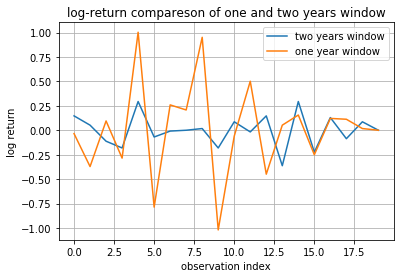

In [33]:
plt.plot(logRLamTwo)
plt.plot(logRLam)
plt.grid(True)
plt.legend(['two years window', 'one year window'])
plt.title("log-return compareson of one and two years window")
plt.xlabel("observation index")
plt.ylabel("log return")

In [34]:
#Using the method mentioned int the Fastrich paper, I performed cross validation to select lambda for Lasso and Ridge 
#regularization seperately. I found for Ridge regularization, the optimal lambda is not sensitive to the random 
#shuffel of the trainning set. However the optimal lambda for Lasso changed a lot among differnt shuffle. Considering
#the shuffling affects the sigma matrix which is the major input for optimization, I suspect that the sigma is greatly
#affected by ramdom selection of the input observations. Hoping to make the sigma estimation more robust, I doubled
#the wondow for cross validation. Here is a graph to show that two years window makes the optimal lambdas more steady.

#figure: performing 10 fold cross valildation with one year and two years window. Data was shuffled ramdomly and
#devided into 10 equal sized groups. lambda was shearched within same intervel and same resollution.

In [367]:
def get_the_window_move(startpoint = 0, traiLen = 250, holdLen = 125, lamUpper = None, lamLower = None, fold = 10, gridNum = 100):
    if lamUpper is None:
        lamUpper = -8
    if lamLower is None:
        lamLower = -13

    trainning = my_data.iloc[startpoint: startpoint + traiLen]
    hold = my_data.iloc[startpoint + traiLen : startpoint + traiLen + holdLen]

    if lamUpper <= lamLower:
        print ("Error: get_the_window_move cannot build lambda series, please check the boundaries of lambda")

    def safeCV(lamLower, lamUpper, trainning, gridNum, reg_type):

        if reg_type == linear_model.Ridge:
            lamUpper = -1
            lamLower = -8
   
        lambdaSeries = np.logspace(lamLower, lamUpper, gridNum)

        _, lam = cross_vali_for_lambda(trainning, lambdaSeries, reg_type = reg_type)
        lower = lam == 1 * 10 ** lamLower
        upper = lam == 1 * 10 ** lamUpper
        if lower or upper :
            
            print(reg_type)
            print("Error: safeCV optimal lambda is on the edge")
            print("Will search bigger interval once and take whatever get")
            if lower :
                lamLower = lamLower - 1
                lamUpper = lamUpper - 1
            else:
                lamLower = lamLower + 1
                lamUpper = lamUpper + 1
            lambdaSeries = np.logspace(lamLower, lamUpper, gridNum)
            _, lam = cross_vali_for_lambda(trainning, lambdaSeries, reg_type=reg_type)
        return lam
    
    lamLasso = safeCV(lamLower, lamUpper, trainning, gridNum, reg_type = linear_model.Lasso)
            
    lamRidge = safeCV(lamLower, lamUpper, trainning, gridNum, reg_type = linear_model.Ridge)
  

        

    sigma = np.cov(trainning.T)
    marPortLS = Markowitz_weights_opt(sigma)
    marPortL = Markowitz_weights_opt(sigma, nonnegative=True)
    
    def portRegularizations(reg_type, lam, sigma):
        clf = reg_type(alpha=lam, fit_intercept=False)
        sig_fit(clf, sigma)
        if clf.coef_.sum() == 0:
            print("Error: cross_vali_for_lambda Sum of coef is zero, too sparse, try smaller lambda")
        weights = clf.coef_ / clf.coef_.sum()
        return weights
    
    lassoPort = portRegularizations(reg_type = linear_model.Lasso, lam = lamLasso, sigma = sigma)
    ridgePort = portRegularizations(reg_type = linear_model.Ridge, lam = lamRidge, sigma = sigma)
    
    posCountLasso = lassoPort[lassoPort != 0].shape[0]
    posCountRidge = ridgePort[ridgePort != 0].shape[0]
    posCountMarLS = marPortL[marPortL != 0].shape[0]
    posCountMarL = marPortL[marPortL != 0].shape[0]
    
    marSLreturns = hold @ marPortLS
    marLreturns = hold @ marPortL
    lassoReturns = hold @ lassoPort
    ridgeReturns = hold @ ridgePort
    
    return posCountLasso, posCountRidge, posCountMarLS, posCountMarL, marSLreturns, marLreturns, lassoReturns, ridgeReturns
    
    



    

    
    

In [153]:
_, _, _, _, marLS, marL, lasso, ridge = get_the_window_move(startpoint = 0, traiLen = 500, holdLen = 125, lamUpper = None, lamLower = None, fold = 10, gridNum = 100)

-9
-9


/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [346]:
activePositions = np.ones([556, 4]) * (-1) #need to at least as big as the  number of window
marLS = np.empty(0)
marL = np.empty(0)
Lasso = np.empty(0)
Ridge = np.empty(0)
start = 0
for i in range(90):
    holdTime = 125
    trainTime = 500
    start += holdTime
    activePositions[i, 0], activePositions[i, 1], activePositions[i, 2], activePositions[i, 3], a, b, c, d = get_the_window_move(startpoint = start, traiLen = trainTime, holdLen = holdTime, lamUpper = None, lamLower = None, fold = 10, gridNum = 500)
    marLS = np.append(marLS, a)
    marL = np.append(marL, b)
    Lasso = np.append(Lasso, c)
    Ridge = np.append(Ridge, d) 

/home/lin/.pyenv/versions/3.6.3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<class 'sklearn.linear_model.ridge.Ridge'>
Error: safeCV optimal lambda is on the edge
Will search bigger interval once and take whatever get
<class 'sklearn.linear_model.ridge.Ridge'>
Error: safeCV optimal lambda is on the edge
Will search bigger interval once and take whatever get
<class 'sklearn.linear_model.ridge.Ridge'>
Error: safeCV optimal lambda is on the edge
Will search bigger interval once and take whatever get
<class 'sklearn.linear_model.ridge.Ridge'>
Error: safeCV optimal lambda is on the edge
Will search bigger interval once and take whatever get
<class 'sklearn.linear_model.ridge.Ridge'>
Error: safeCV optimal lambda is on the edge
Will search bigger interval once and take whatever get
<class 'sklearn.linear_model.ridge.Ridge'>
Error: safeCV optimal lambda is on the edge
Will search bigger interval once and take whatever get
<class 'sklearn.linear_model.ridge.Ridge'>
Error: safeCV optimal lambda is on the edge
Will search bigger interval once and take whatever get
<class

In [347]:
%matplotlib tk
plt.plot(np.zeros(marLS.shape[0]))
plt.plot(marL, linewidth = 0.7)
plt.plot(marLS, linewidth = 0.7)
plt.plot(Lasso, linewidth = 0.7)
plt.plot(Ridge, lineWidth = 0.7)
plt.legend(['zero benchmark', 'MarL', 'MarLS', 'Lasso', 'Ridge'])

In [348]:
marLS.std()

0.4757613414552553

In [349]:
marL.std()

0.6373582655987203

In [350]:
Lasso.std()

0.5198655578871443

In [351]:
Ridge.std()

0.477050139817354

In [352]:
activePositions

array([[38., 48., 48., 48.],
       [35., 48., 48., 48.],
       [35., 48., 48., 48.],
       ...,
       [-1., -1., -1., -1.],
       [-1., -1., -1., -1.],
       [-1., -1., -1., -1.]])

In [353]:
returns_0_500_125_500_biggerInterval = pd.DataFrame()

returns_0_500_125_500_biggerInterval['MarLS'] = marLS
returns_0_500_125_500_biggerInterval['MarL'] = marL
returns_0_500_125_500_biggerInterval['Lasso'] = Lasso
returns_0_500_125_500_biggerInterval['Ridge'] = Ridge
active_0_500_125_500_biggerInterval = pd.DataFrame()
active_0_500_125_500_biggerInterval['Lasso'] = activePositions[:, 0]
active_0_500_125_500_biggerInterval['Ridge'] = activePositions[:, 1]
active_0_500_125_500_biggerInterval['MarLS'] = activePositions[:, 2]
active_0_500_125_500_biggerInterval['MarL'] = activePositions[:, 3]


returns_0_500_125_500_biggerInterval.to_csv('/home/lin/教材/MearchineLearning/assignmentOneData/returns_0_500_125_500_biggerInterval.csv')
active_0_500_125_500_biggerInterval.to_csv('/home/lin/教材/MearchineLearning/assignmentOneData/active_0_500_125_500_biggerInterval.csv')

In [331]:
(12196 - 500) /21

556.952380952381

In [319]:
my_data.shape

(12196, 48)